Saving minordata.xlsx to minordata (6).xlsx


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:27:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 99.10%

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00        12
           b       1.00      1.00      1.00        12
           c       1.00      1.00      1.00        20
           d       0.97      1.00      0.99        34
           e       1.00      0.97      0.98        33

    accuracy                           0.99       111
   macro avg       0.99      0.99      0.99       111
weighted avg       0.99      0.99      0.99       111



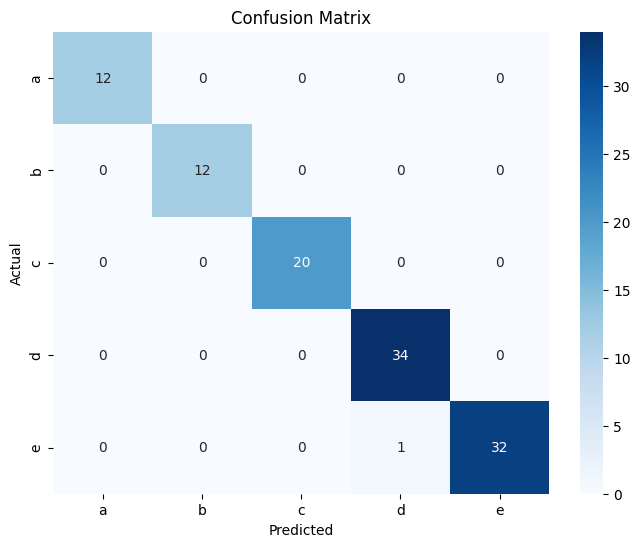


Sample Test Data Predictions:
  Actual Grade Predicted Grade
0            e               e
1            e               e
2            d               d
3            d               d
4            b               b


In [ ]:
# Step 1: Install Libraries
!pip install pandas openpyxl scikit-learn xgboost

# Step 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Upload your file
from google.colab import files
uploaded = files.upload()

# Step 4: Load your Excel file (Replace 'yourfile.xlsx' with actual uploaded file name)
filename = list(uploaded.keys())[0]  # automatically picks the uploaded file name
df = pd.read_excel(filename)

# Step 5: Select only required columns
selected_columns = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g',
    'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'salt_100g', 'sodium_100g', 'iron_100g',
    'ingredients_text', 'additives_n', 'additives',
    'nutrition_grade_fr', 'nutrition-score-fr_100g'
]
df = df[selected_columns]

# Step 6: Handle Missing Values
# Fill numeric columns with their median
num_cols = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g',
    'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'salt_100g', 'sodium_100g', 'iron_100g',
    'additives_n', 'nutrition-score-fr_100g'
]
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill text columns with "Unknown"
text_cols = ['ingredients_text', 'additives']
for col in text_cols:
    df[col] = df[col].fillna('Unknown')

# Drop rows where target 'nutrition_grade_fr' is missing
df = df.dropna(subset=['nutrition_grade_fr'])

# Step 7: Encode Target Variable
label_encoder = LabelEncoder()
df['nutrition_grade_fr_encoded'] = label_encoder.fit_transform(df['nutrition_grade_fr'])

# Step 8: Prepare X and y
X = df.drop(['nutrition_grade_fr', 'nutrition_grade_fr_encoded'], axis=1)
# Convert text columns to basic numerical features (length)
X['ingredients_text_length'] = X['ingredients_text'].apply(lambda x: len(x))
X['additives_text_length'] = X['additives'].apply(lambda x: len(x))
X = X.drop(['ingredients_text', 'additives'], axis=1)

y = df['nutrition_grade_fr_encoded']

# Step 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 10: Train XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Step 11: Evaluate Model
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 12: Test Sample Predictions
print("\nSample Test Data Predictions:")
sample_X = X_test.sample(5, random_state=42)
sample_y_true = y_test.loc[sample_X.index]
sample_y_pred = model.predict(sample_X)

sample_results = pd.DataFrame({
    'Actual Grade': label_encoder.inverse_transform(sample_y_true),
    'Predicted Grade': label_encoder.inverse_transform(sample_y_pred)
})
print(sample_results)
